Synthetic Data Generation

In [41]:
import torch
import numpy as np

def generate_synthetic_dataset(T=10, S=5, K=40, N=50, r=3):
    W0 = 0.1 * torch.randn(N, N)
    U, _, Vt = torch.linalg.svd(W0)
    U = U[:, :r]
    V = Vt[:r, :].T

    B = 0.05 * torch.randn(N, 1)
    b = 0.1 * torch.randn(N)
    R = torch.randn(1, N) * 0.05

    t_vals = torch.linspace(0, 2 * np.pi, T)
    z = torch.stack([torch.sin(t_vals + np.pi * i / r) + 0.1 * t_vals for i in range(r)], dim=1)

    x_full = torch.zeros(T, S, K, N)
    v_full = torch.zeros(T, S, K)
    u_full = torch.zeros(T, S, K)

    for t in range(T):
        Wt = W0 + U @ torch.diag(z[t]) @ V.T
        for s in range(S):
            v = torch.randn(K) * 0.5
            x = torch.zeros(K, N)
            x[0] = torch.randn(N) * 0.1
            for k in range(K - 1):
                x[k + 1] = torch.tanh(Wt @ x[k] + (B * v[k]).squeeze() + b)
            u_hat = (R @ x.T).squeeze()
            x_full[t, s] = x
            v_full[t, s] = v
            u_full[t, s] = u_hat + 0.05 * torch.randn(K)
    return x_full, v_full, u_full, W0, U, V, z, B, b, R

# Generate
x, v, u, W0, U, V, z_true, B, b, R = generate_synthetic_dataset()


 Dataset Class

In [42]:
from torch.utils.data import Dataset, DataLoader

class SplitSessionDataset(Dataset):
    def __init__(self, x, v, u, train_days):
        self.x = x
        self.v = v
        self.u = u
        self.train_days = train_days
        self.S = x.shape[1]

    def __len__(self):
        return len(self.train_days) * self.S

    def __getitem__(self, idx):
        t_idx = self.train_days[idx // self.S]
        s = idx % self.S
        return self.x[t_idx, s], self.v[t_idx, s], self.u[t_idx, s], t_idx


Model Definition

In [43]:
import torch.nn as nn
from torchdiffeq import odeint

class SlowODE(nn.Module):
    def __init__(self, r):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(r + 1, 64),
            nn.Tanh(),
            nn.Linear(64, r)
        )

    def forward(self, t, z):
        if isinstance(t, torch.Tensor):
            t = t.item()
        tvec = torch.full_like(z[:, :1], t)
        return self.net(torch.cat([z, tvec], dim=1))

class PINN_RNN(nn.Module):
    def __init__(self, N, r, W0, learn_UV=False):
        super().__init__()
        self.W0 = nn.Parameter(W0)
        U, _, Vt = torch.linalg.svd(W0)
        self.U = nn.Parameter(U[:, :r]) if learn_UV else U[:, :r].detach()
        self.V = nn.Parameter(Vt[:r, :].T) if learn_UV else Vt[:r, :].T.detach()

        self.z0 = nn.Parameter(torch.zeros(r))
        self.slow = SlowODE(r)
        self.B = nn.Parameter(torch.randn(N, 1) * 0.01)
        self.R = nn.Parameter(torch.randn(1, N) * 0.01)
        self.b_fixed = None

    def set_fixed_bias(self, b):
        self.b_fixed = b

    def rnn_cell(self, x, v, W):
        return torch.tanh((W @ x) + (self.B * v).squeeze() + self.b_fixed)

    def weights_over_time(self, T):
        times = torch.arange(T, dtype=torch.float32)
        z0_cpu = self.z0.unsqueeze(0).float()
        z_cpu = odeint(self.slow, z0_cpu, times).squeeze(1)
        return self.W0 + self.U @ torch.diag_embed(z_cpu) @ self.V.T

    def forward(self, x0, v, t, Ws):
        W = Ws[t]
        K, N = x0.shape
        x_list = [x0[0]]
        rec = dec = upd = 0
        for s in range(K - 1):
            up = self.rnn_cell(x_list[s], v[s], W)
            rec += (x_list[s] - x0[s]).pow(2).sum()
            dec += (self.R @ x_list[s] - v[s].unsqueeze(0)).pow(2).sum()
            upd += (up - self.rnn_cell(x_list[s], v[s], W)).pow(2).sum()
            x_list.append(up)
        return rec, dec, upd


Training Loop 

In [44]:
train_days = list(range(7))
dataset = SplitSessionDataset(x, v, u, train_days)
loader = DataLoader(dataset, batch_size=2, shuffle=True)

model = PINN_RNN(N=x.shape[-1], r=3, W0=W0, learn_UV=True)
model.set_fixed_bias(b)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

for ep in range(20):
    L = 0
    for x_batch, v_batch, u_batch, t_batch in loader:
        Ws = model.weights_over_time(x.shape[0]).detach()   # ✅ moved here + detach()
        loss = 0
        for i in range(x_batch.shape[0]):
            Rloss, Dloss, Uloss = model(x_batch[i], v_batch[i], t_batch[i], Ws)
            loss += Rloss + Dloss + 0.01 * Uloss
        loss /= x_batch.shape[0]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        L += loss.item()
    print(f"Epoch {ep:02d} | Loss: {L/len(loader):.4f}")


Epoch 00 | Loss: 11.3196
Epoch 01 | Loss: 10.7996
Epoch 02 | Loss: 10.6524
Epoch 03 | Loss: 10.7107
Epoch 04 | Loss: 10.5197
Epoch 05 | Loss: 10.5311
Epoch 06 | Loss: 10.4809
Epoch 07 | Loss: 10.5798
Epoch 08 | Loss: 10.5709
Epoch 09 | Loss: 10.5601
Epoch 10 | Loss: 10.5233
Epoch 11 | Loss: 10.5618
Epoch 12 | Loss: 10.4702
Epoch 13 | Loss: 10.5954
Epoch 14 | Loss: 10.5865
Epoch 15 | Loss: 10.6384
Epoch 16 | Loss: 10.4426
Epoch 17 | Loss: 10.4562
Epoch 18 | Loss: 10.4994
Epoch 19 | Loss: 10.5884


 Day n+1 Prediction + Plotting

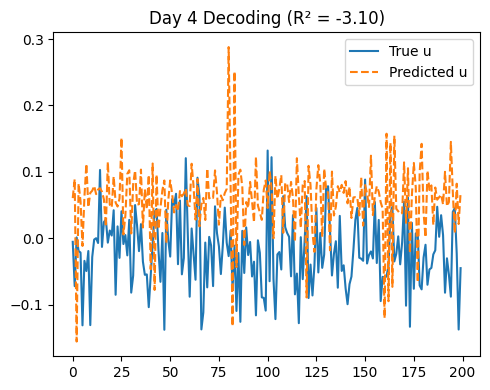

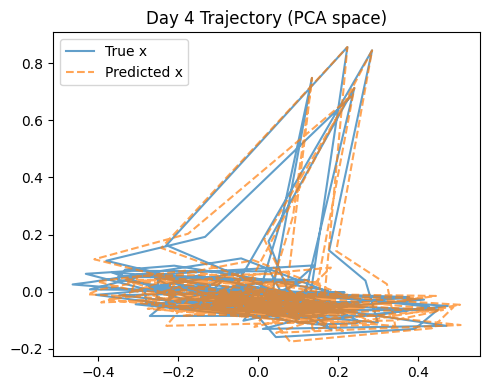

In [45]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA

def predict_session(model, x_true, v_true, u_true, Ws, day_idx):
    W = Ws[day_idx]
    S, K, N = x_true.shape
    y_pred_all = []
    y_true_all = []
    x_obs_all = []
    x_pred_all = []

    for s in range(S):
        x0 = x_true[s]
        v = v_true[s]
        u = u_true[s]
        x_list = [x0[0]]
        for k in range(K - 1):
            x_list.append(model.rnn_cell(x_list[-1], v[k], W))
        x_pred = torch.stack(x_list, dim=0)
        u_pred = (model.R @ x_pred.T).squeeze()

        y_true_all.append(u.numpy())
        y_pred_all.append(u_pred.detach().numpy())
        x_obs_all.append(x0.numpy())
        x_pred_all.append(x_pred.detach().numpy())

    return (
        np.concatenate(y_true_all),
        np.concatenate(y_pred_all),
        np.concatenate(x_obs_all),
        np.concatenate(x_pred_all),
    )

predict_day = 4
y_true, y_pred, X_obs, X_pred = predict_session(model, x[predict_day], v[predict_day], u[predict_day], Ws, predict_day)

# R² score
r2 = r2_score(y_true, y_pred)
plt.figure(figsize=(5, 4))
plt.plot(y_true, label="True u")
plt.plot(y_pred, label="Predicted u", linestyle="--")
plt.title(f"Day {predict_day} Decoding (R² = {r2:.2f})")
plt.legend()
plt.tight_layout()
plt.show()

# PCA plot
pca = PCA(n_components=2)
X_obs_pca = pca.fit_transform(X_obs)
X_pred_pca = pca.transform(X_pred)

plt.figure(figsize=(5, 4))
plt.plot(X_obs_pca[:, 0], X_obs_pca[:, 1], label="True x", alpha=0.7)
plt.plot(X_pred_pca[:, 0], X_pred_pca[:, 1], label="Predicted x", linestyle="--", alpha=0.7)
plt.title(f"Day {predict_day} Trajectory (PCA space)")
plt.legend()
plt.tight_layout()
plt.show()


Device: cpu
Epoch  0: Loss = 118.7897
Epoch  1: Loss = 90.3561
Epoch  2: Loss = 97.2406
Epoch  3: Loss = 84.7350
Epoch  4: Loss = 84.1435
Epoch  5: Loss = 85.0475
Epoch  6: Loss = 94.0163
Epoch  7: Loss = 83.5543
Epoch  8: Loss = 82.7104
Epoch  9: Loss = 81.6965
Epoch 10: Loss = 81.4608
Epoch 11: Loss = 81.8430
Epoch 12: Loss = 80.6171
Epoch 13: Loss = 80.3939
Epoch 14: Loss = 80.0811
Epoch 15: Loss = 80.1688
Epoch 16: Loss = 80.3751
Epoch 17: Loss = 79.3542
Epoch 18: Loss = 78.3797
Epoch 19: Loss = 78.0570


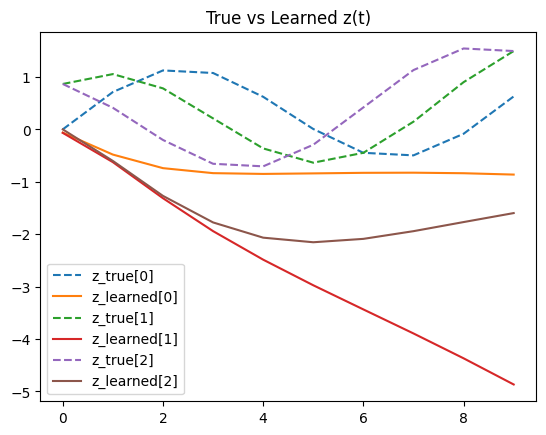

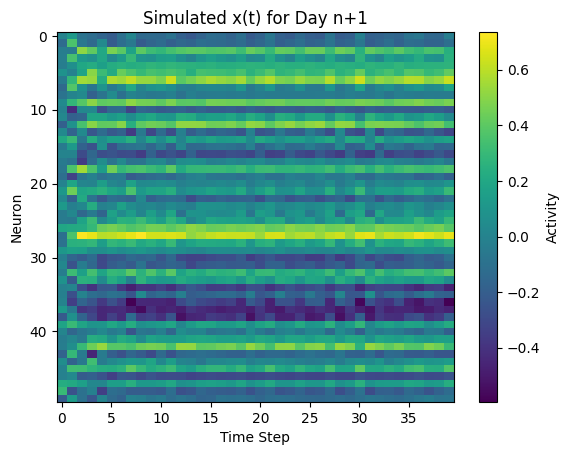

In [60]:
# Symmetry-Constrained PINN-RNN for Structured Drift Recovery
# ===========================================================
# This notebook simulates representational drift across days and trains a physics-informed RNN
# to learn structured synaptic changes using a latent low-rank ODE.

# -----------------------
# Setup
# -----------------------
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchdiffeq import odeint
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy.linalg import subspace_angles

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -----------------------
# Generate Synthetic Data
# -----------------------
def generate_synthetic_dataset(T=10, S=5, K=40, N=50, r=3):
    W0 = 0.1 * torch.randn(N, N)
    U, _, Vt = torch.linalg.svd(W0)
    U = U[:, :r]
    V = Vt[:r, :].T

    B = 0.05 * torch.randn(N, 1)
    b = 0.1 * torch.randn(N)
    R = torch.randn(1, N) * 0.05

    t_vals = torch.linspace(0, 2 * np.pi, T)
    z = torch.stack([torch.sin(t_vals + np.pi * i / r) + 0.1 * t_vals for i in range(r)], dim=1)

    x_full = torch.zeros(T, S, K, N)
    v_full = torch.zeros(T, S, K)
    u_full = torch.zeros(T, S, K)

    for t in range(T):
        Wt = W0 + U @ torch.diag_embed(z[t].unsqueeze(0)).squeeze(0) @ V.T
        for s in range(S):
            v = torch.randn(K) * 0.5
            x = torch.zeros(K, N)
            x[0] = torch.randn(N) * 0.1
            for k in range(K - 1):
                x[k + 1] = torch.tanh(Wt @ x[k] + (B * v[k]).squeeze() + b)
            u_hat = (R @ x.T).squeeze()
            x_full[t, s] = x
            v_full[t, s] = v
            u_full[t, s] = u_hat + 0.05 * torch.randn(K)

    return x_full, v_full, u_full, W0, U, V, z, B, b, R

# Generate data
x, v, u, W0, U, V, z_true, B, b, R = generate_synthetic_dataset()
T, S, K, N = x.shape
rank = z_true.shape[1]

# -----------------------
# Dataset
# -----------------------
class SplitSessionDataset(Dataset):
    def __init__(self, x, v, u, train_days):
        self.x = x
        self.v = v
        self.u = u
        self.train_days = train_days
        self.S = x.shape[1]

    def __len__(self):
        return len(self.train_days) * self.S

    def __getitem__(self, idx):
        t_idx = self.train_days[idx // self.S]
        s = idx % self.S
        return self.x[t_idx, s], self.v[t_idx, s], self.u[t_idx, s], t_idx

# -----------------------
# Model
# -----------------------
class SlowODE(nn.Module):
    def __init__(self, r):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(r + 1, 64),
            nn.Tanh(),
            nn.Linear(64, r)
        )

    def forward(self, t, z):
        if isinstance(t, torch.Tensor):
            t = t.item()
        tvec = torch.full_like(z[:, :1], t)
        return self.net(torch.cat([z, tvec], dim=1))

class PINN_RNN(nn.Module):
    def __init__(self, N, r, U, V, W0, b_fixed):
        super().__init__()
        self.U = U.to(device)
        self.V = V.to(device)
        self.W0 = W0.to(device)
        self.z0 = nn.Parameter(torch.zeros(r))
        self.slow = SlowODE(r)
        self.B = nn.Parameter(torch.randn(N, 1) * 0.01)
        self.b_fixed = b_fixed.to(device)
        self.R = nn.Parameter(torch.randn(1, N) * 0.01)

    def rnn_cell(self, x, v, W):
        return torch.tanh((W @ x) + (self.B * v).squeeze() + self.b_fixed)

    def weights_over_time(self, T):
        times = torch.arange(T, dtype=torch.float32)
        z_traj = odeint(self.slow, self.z0.unsqueeze(0), times).squeeze(1)
        return self.W0 + self.U @ torch.diag_embed(z_traj) @ self.V.T

    def forward(self, x0, v, t, Ws):
        W = Ws[t]
        K, N = x0.shape
        x_list = [x0[0]]
        rec = dec = upd = 0
        for k in range(K - 1):
            up = self.rnn_cell(x_list[k], v[k], W)
            rec += (x_list[k] - x0[k]).pow(2).sum()
            dec += (self.R @ x_list[k] - v[k].unsqueeze(0)).pow(2).sum()
            upd += (up - self.rnn_cell(x_list[k], v[k], W)).pow(2).sum()
            x_list.append(up)
        return rec, dec, upd

# -----------------------
# Training
# -----------------------
train_days = list(range(T-1))
dataset = SplitSessionDataset(x, v, u, train_days)
loader = DataLoader(dataset, batch_size=4, shuffle=True)
b_fixed = x.mean(dim=(0,1,2)).to(device)
model = PINN_RNN(N, rank, U, V, W0, b_fixed=b_fixed).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

loss_history = {"rec": [], "dec": [], "upd": []}
epochs = 20

for ep in range(epochs):
    total_loss = 0
    for x_batch, v_batch, u_batch, t_batch in loader:
        x_batch, v_batch, t_batch = x_batch.to(device), v_batch.to(device), t_batch.to(device)
        Ws = model.weights_over_time(T)  # keep graph

        loss = 0
        for i in range(x_batch.shape[0]):
            R, D, U = model(x_batch[i], v_batch[i], t_batch[i], Ws)
            loss += R + D + 0.01 * U
            loss_history["rec"].append(R.item())
            loss_history["dec"].append(D.item())
            loss_history["upd"].append(U.item())

        loss /= x_batch.shape[0]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {ep:2d}: Loss = {total_loss/len(loader):.4f}")

# -----------------------
# Evaluation: Drift Recovery
# -----------------------
z_learned = odeint(model.slow, model.z0.unsqueeze(0), torch.arange(T).float()).squeeze(1).detach()

plt.figure()
for i in range(rank):
    plt.plot(z_true[:, i], '--', label=f'z_true[{i}]')
    plt.plot(z_learned[:, i], label=f'z_learned[{i}]')
plt.legend()
plt.title("True vs Learned z(t)")
plt.show()

# Subspace similarity
# def subspace_similarity(W1, W2, k=5):
#     _, _, V1 = torch.linalg.svd(W1)
#     _, _, V2 = torch.linalg.svd(W2)
#     return np.mean(np.cos(subspace_angles(V1[:, :k].cpu().numpy(), V2[:, :k].cpu().numpy())))

# Ws_true = []
# for t in range(T):
#     z_diag = torch.diag_embed(z_true[t].unsqueeze(0)).squeeze(0)
#     Wt = W0 + U @ z_diag @ V.T  # ensure [N, r] @ [r, r] @ [r, N]
#     Ws_true.append(Wt)
# Ws_learned = model.weights_over_time(T).detach()

# similarities = [subspace_similarity(Ws_learned[t], Ws_true[t]) for t in range(T)]
# plt.plot(similarities)
# plt.title("Subspace Similarity of W(t)")
# plt.ylim(0, 1)
# plt.show()

# -----------------------
# Day n+1 Prediction + Plotting
# -----------------------
T_plus1 = T
z_pred_all = odeint(model.slow, model.z0.unsqueeze(0), torch.arange(T_plus1).float()).squeeze(1).detach()
z_last = z_pred_all[-1].unsqueeze(0)  # [1, r]
z_diag = torch.diag_embed(z_last)[0]  # [r, r]
W_next = model.W0 + model.U @ z_diag @ model.V.T

x0 = x[-1, 0]  # use session T-1, trial 0 as seed
v_future = torch.randn(K).to(device)
x_sim = [x0[0]]
for k in range(K - 1):
    x_sim.append(torch.tanh(W_next @ x_sim[-1] + (model.B * v_future[k]).squeeze() + model.b_fixed))
x_sim = torch.stack(x_sim)

plt.figure()
plt.imshow(x_sim.detach().cpu().numpy().T, aspect='auto', cmap='viridis')
plt.title("Simulated x(t) for Day n+1")
plt.xlabel("Time Step")
plt.ylabel("Neuron")
plt.colorbar(label="Activity")
plt.show()


Device: cpu
Epoch  0: Loss = 82.1075
Epoch  1: Loss = 77.8150
Epoch  2: Loss = 75.2498
Epoch  3: Loss = 73.0009
Epoch  4: Loss = 71.4956
Epoch  5: Loss = 70.4205
Epoch  6: Loss = 69.8067
Epoch  7: Loss = 69.6002
Epoch  8: Loss = 69.3667
Epoch  9: Loss = 69.1160
Epoch 10: Loss = 68.9050
Epoch 11: Loss = 68.7293
Epoch 12: Loss = 68.5688
Epoch 13: Loss = 68.4227
Epoch 14: Loss = 68.2814
Epoch 15: Loss = 68.1516
Epoch 16: Loss = 68.0473
Epoch 17: Loss = 67.9676
Epoch 18: Loss = 67.8302
Epoch 19: Loss = 67.7472


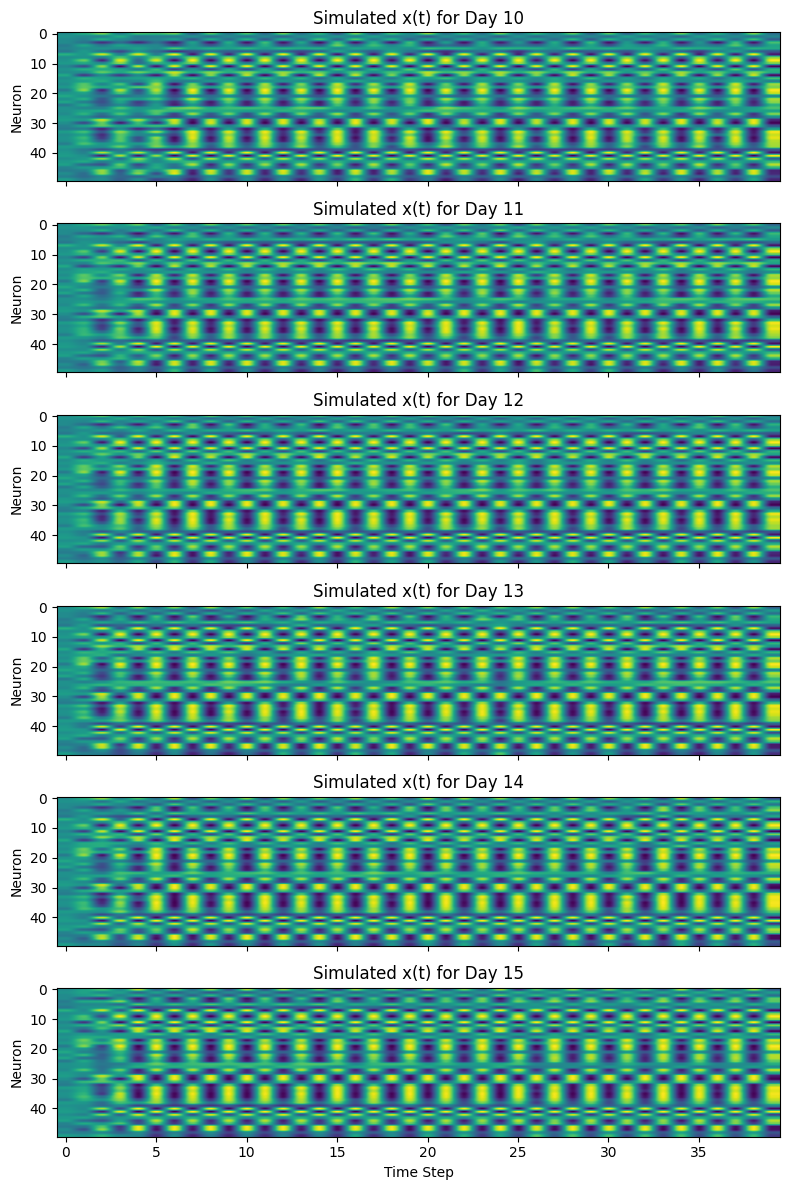

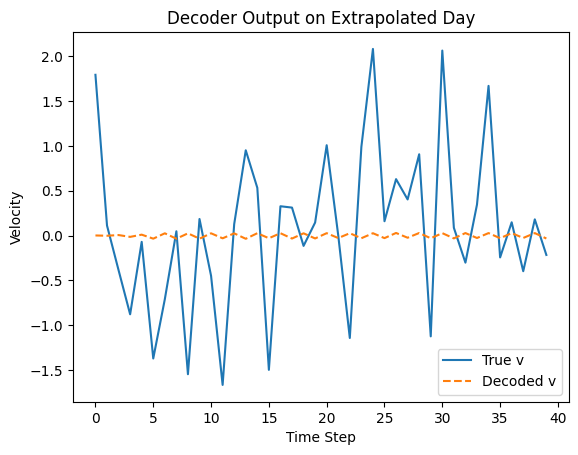

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

<Figure size 640x480 with 0 Axes>

In [ ]:
# Symmetry-Constrained PINN-RNN for Structured Drift Recovery
# ===========================================================
# This notebook simulates representational drift across days and trains a physics-informed RNN
# to learn structured synaptic changes using a latent low-rank ODE.

# -----------------------
# Setup
# -----------------------
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchdiffeq import odeint
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy.linalg import subspace_angles

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -----------------------
# Generate Synthetic Data
# -----------------------
def generate_synthetic_dataset(T=10, S=5, K=40, N=50, r=3):
    W0 = 0.1 * torch.randn(N, N)
    U, _, Vt = torch.linalg.svd(W0)
    U = U[:, :r]
    V = Vt[:r, :].T

    B = 0.05 * torch.randn(N, 1)
    b = 0.1 * torch.randn(N)
    R = torch.randn(1, N) * 0.05

    t_vals = torch.linspace(0, 2 * np.pi, T)
    z = torch.stack([torch.sin(t_vals + np.pi * i / r) + 0.1 * t_vals for i in range(r)], dim=1)

    x_full = torch.zeros(T, S, K, N)
    v_full = torch.zeros(T, S, K)
    u_full = torch.zeros(T, S, K)

    for t in range(T):
        Wt = W0 + U @ torch.diag_embed(z[t].unsqueeze(0)).squeeze(0) @ V.T
        for s in range(S):
            v = torch.randn(K) * 0.5
            x = torch.zeros(K, N)
            x[0] = torch.randn(N) * 0.1
            for k in range(K - 1):
                x[k + 1] = torch.tanh(Wt @ x[k] + (B * v[k]).squeeze() + b)
            u_hat = (R @ x.T).squeeze()
            x_full[t, s] = x
            v_full[t, s] = v
            u_full[t, s] = u_hat + 0.05 * torch.randn(K)

    return x_full, v_full, u_full, W0, U, V, z, B, b, R

# Generate data
x, v, u, W0, U, V, z_true, B, b, R = generate_synthetic_dataset()
T, S, K, N = x.shape
rank = z_true.shape[1]

# -----------------------
# Dataset
# -----------------------
class SplitSessionDataset(Dataset):
    def __init__(self, x, v, u, train_days):
        self.x = x
        self.v = v
        self.u = u
        self.train_days = train_days
        self.S = x.shape[1]

    def __len__(self):
        return len(self.train_days) * self.S

    def __getitem__(self, idx):
        t_idx = self.train_days[idx // self.S]
        s = idx % self.S
        return self.x[t_idx, s], self.v[t_idx, s], self.u[t_idx, s], t_idx

# -----------------------
# Model
# -----------------------
class SlowODE(nn.Module):
    def __init__(self, r):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(r + 1, 64),
            nn.Tanh(),
            nn.Linear(64, r)
        )

    def forward(self, t, z):
        if isinstance(t, torch.Tensor):
            t = t.item()
        tvec = torch.full_like(z[:, :1], t)
        return self.net(torch.cat([z, tvec], dim=1))

class PINN_RNN(nn.Module):
    def __init__(self, N, r, U, V, W0, b_fixed):
        super().__init__()
        self.U = U.to(device)
        self.V = V.to(device)
        self.W0 = W0.to(device)
        self.z0 = nn.Parameter(torch.zeros(r))
        self.slow = SlowODE(r)
        self.B = nn.Parameter(torch.randn(N, 1) * 0.01)
        self.b_fixed = b_fixed.to(device)
        self.R = nn.Parameter(torch.randn(1, N) * 0.01)

    def rnn_cell(self, x, v, W):
        return torch.tanh((W @ x) + (self.B * v).squeeze() + self.b_fixed)

    def weights_over_time(self, T):
        times = torch.arange(T, dtype=torch.float32)
        z_traj = odeint(self.slow, self.z0.unsqueeze(0), times).squeeze(1)
        return self.W0 + self.U @ torch.diag_embed(z_traj) @ self.V.T

    def forward(self, x0, v, t, Ws):
        W = Ws[t]
        K, N = x0.shape
        x_list = [x0[0]]
        rec = dec = upd = 0
        for k in range(K - 1):
            up = self.rnn_cell(x_list[k], v[k], W)
            rec += (x_list[k] - x0[k]).pow(2).sum()
            dec += (self.R @ x_list[k] - v[k].unsqueeze(0)).pow(2).sum()
            upd += (up - self.rnn_cell(x_list[k], v[k], W)).pow(2).sum()
            x_list.append(up)
        return rec, dec, upd

# -----------------------
# Training
# -----------------------
train_days = list(range(4))  # use only first 4 days for training
dataset = SplitSessionDataset(x, v, u, train_days)
loader = DataLoader(dataset, batch_size=4, shuffle=True)
b_fixed = x.mean(dim=(0,1,2)).to(device)
model = PINN_RNN(N, rank, U, V, W0, b_fixed=b_fixed).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

loss_history = {"rec": [], "dec": [], "upd": []}
epochs = 20

for ep in range(epochs):
    total_loss = 0
    for x_batch, v_batch, u_batch, t_batch in loader:
        x_batch, v_batch, t_batch = x_batch.to(device), v_batch.to(device), t_batch.to(device)
        Ws = model.weights_over_time(T)  # keep graph

        loss = 0
        for i in range(x_batch.shape[0]):
            R, D, U = model(x_batch[i], v_batch[i], t_batch[i], Ws)
            loss += R + D + 0.01 * U
            loss_history["rec"].append(R.item())
            loss_history["dec"].append(D.item())
            loss_history["upd"].append(U.item())

        loss /= x_batch.shape[0]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {ep:2d}: Loss = {total_loss/len(loader):.4f}")

# -----------------------
# Day n+1 to Day n+6 Prediction + Plotting

T_future = 6  # how many future days to extrapolate
T_total = T + T_future
z_pred_all = odeint(model.slow, model.z0.unsqueeze(0), torch.arange(T_total).float()).squeeze(1).detach()

fig, axs = plt.subplots(T_future, 1, figsize=(8, 2*T_future), sharex=True)
for f in range(T_future):
    t_future = T + f
    z_diag = torch.diag_embed(z_pred_all[t_future].unsqueeze(0)).squeeze(0)
    W_future = model.W0 + model.U @ z_diag @ model.V.T

    x0 = x[0, 0]  # use early trial as seed
    v_future = torch.randn(K).to(device)
    x_sim = [x0[0]]
    for k in range(K - 1):
        x_sim.append(torch.tanh(W_future @ x_sim[-1] + (model.B * v_future[k]).squeeze() + model.b_fixed))
    x_sim = torch.stack(x_sim)

    axs[f].imshow(x_sim.detach().cpu().numpy().T, aspect='auto', cmap='viridis')
    axs[f].set_title(f"Simulated x(t) for Day {t_future}")
    axs[f].set_ylabel("Neuron")
axs[-1].set_xlabel("Time Step")
plt.tight_layout()
plt.show()

# Decode velocity from last future day
x_dec = x_sim  # last x_sim from loop
v_decoded = (model.R @ x_dec.T).squeeze().detach().cpu().numpy()
plt.figure()
plt.plot(v_future.cpu().numpy(), label="True v")
plt.plot(v_decoded, label="Decoded v", linestyle='--')
plt.legend()
plt.title("Decoder Output on Extrapolated Day")
plt.xlabel("Time Step")
plt.ylabel("Velocity")
plt.show()
# -----------------------
T_plus1 = T + 1
z_pred_all = odeint(model.slow, model.z0.unsqueeze(0), torch.arange(T_plus1).float()).squeeze(1).detach()
z_last = z_pred_all[-1].unsqueeze(0)  # [1, r]
z_diag = torch.diag_embed(z_last)[0]  # [r, r]
W_next = model.W0 + model.U @ z_diag @ model.V.T

x0 = x[-1, 0]  # use session T-1, trial 0 as seed
v_future = torch.randn(K).to(device)
x_sim = [x0[0]]
for k in range(K - 1):
    x_sim.append(torch.tanh(W_next @ x_sim[-1] + (model.B * v_future[k]).squeeze() + model.b_fixed))
x_sim = torch.stack(x_sim)

plt.figure()
plt.imshow(x_sim.detach().cpu().numpy().T, aspect='auto', cmap='viridis')
plt.title("Simulated x(t) for Day n+1")
plt.xlabel("Time Step")
plt.ylabel("Neuron")
plt.colorbar(label="Activity")
plt.show()


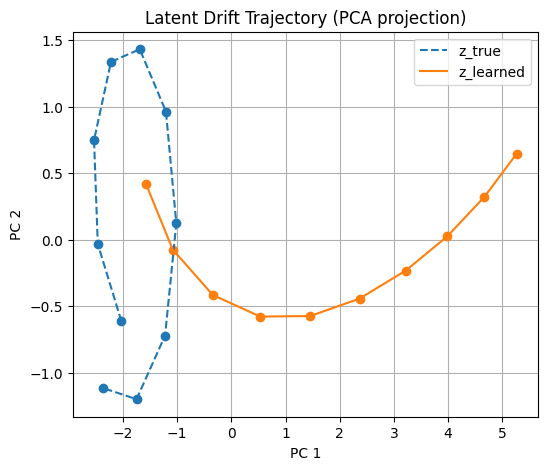

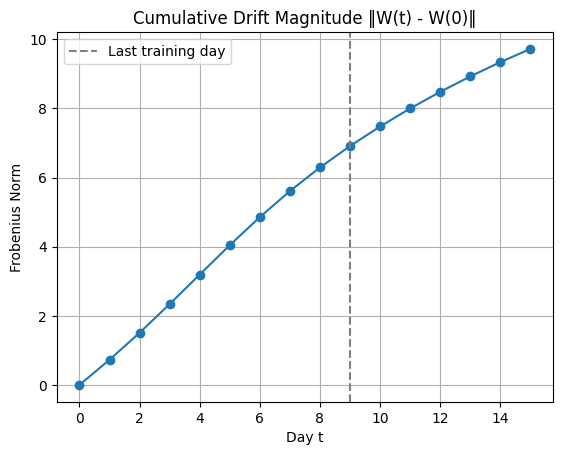

IndexError: index 11 is out of bounds for dimension 0 with size 11

In [62]:
from sklearn.decomposition import PCA

# Combine z_true and z_learned for projection
if 'z_true' in globals():
    z_learned = odeint(model.slow, model.z0.unsqueeze(0), torch.arange(T).float()).squeeze(1).detach()
    all_z = torch.cat([z_true, z_learned], dim=0).cpu().numpy()
    labels = ['true'] * T + ['learned'] * T
    z_pca = PCA(n_components=2).fit_transform(all_z)

    plt.figure(figsize=(6, 5))
    for i in range(2*T):
        style = '--' if labels[i] == 'true' else '-'
        plt.plot(z_pca[i, 0], z_pca[i, 1], 'o', color='C0' if labels[i]=='true' else 'C1')
    plt.plot(z_pca[:T, 0], z_pca[:T, 1], '--', label='z_true', color='C0')
    plt.plot(z_pca[T:, 0], z_pca[T:, 1], '-', label='z_learned', color='C1')
    plt.legend()
    plt.title("Latent Drift Trajectory (PCA projection)")
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.grid(True)
    plt.show()




W_all = model.weights_over_time(T + T_future).detach()
drift_magnitudes = [torch.norm(W_all[t] - W_all[0]).item() for t in range(T + T_future)]

plt.figure()
plt.plot(range(T + T_future), drift_magnitudes, marker='o')
plt.axvline(x=T-1, color='gray', linestyle='--', label='Last training day')
plt.title("Cumulative Drift Magnitude ‖W(t) - W(0)‖")
plt.xlabel("Day t")
plt.ylabel("Frobenius Norm")
plt.legend()
plt.grid(True)
plt.show()




from sklearn.metrics import r2_score

r2_scores = []
for f in range(T_future):
    t_future = T + f
    z_diag = torch.diag_embed(z_pred_all[t_future].unsqueeze(0)).squeeze(0)
    W_future = model.W0 + model.U @ z_diag @ model.V.T

    # Simulate one trial
    x_seed = x[0, 0]
    v_sim = torch.randn(K).to(device)
    x_gen = [x_seed[0]]
    for k in range(K - 1):
        x_gen.append(torch.tanh(W_future @ x_gen[-1] + (model.B * v_sim[k]).squeeze() + model.b_fixed))
    x_gen = torch.stack(x_gen)
    v_decoded = (model.R @ x_gen.T).squeeze().detach().cpu().numpy()

    r2_scores.append(r2_score(v_sim.cpu().numpy(), v_decoded))

plt.figure()
plt.plot(range(T, T + T_future), r2_scores, marker='o')
plt.title("Decoder R² Over Future Days")
plt.xlabel("Day")
plt.ylabel("R² Score")
plt.ylim(0, 1)
plt.grid(True)
plt.show()


Device: cpu
Epoch  0: Loss = 118.7897
Epoch  1: Loss = 90.3561
Epoch  2: Loss = 97.2406
Epoch  3: Loss = 84.7350
Epoch  4: Loss = 84.1435
Epoch  5: Loss = 85.0475
Epoch  6: Loss = 94.0163
Epoch  7: Loss = 83.5543
Epoch  8: Loss = 82.7104
Epoch  9: Loss = 81.6965
Epoch 10: Loss = 81.4608
Epoch 11: Loss = 81.8430
Epoch 12: Loss = 80.6171
Epoch 13: Loss = 80.3939
Epoch 14: Loss = 80.0811
Epoch 15: Loss = 80.1688
Epoch 16: Loss = 80.3751
Epoch 17: Loss = 79.3542
Epoch 18: Loss = 78.3797
Epoch 19: Loss = 78.0570


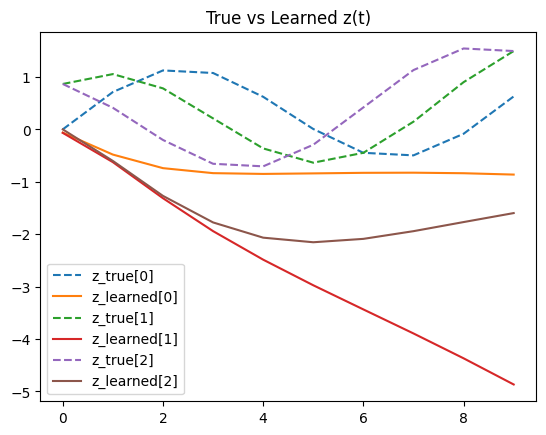

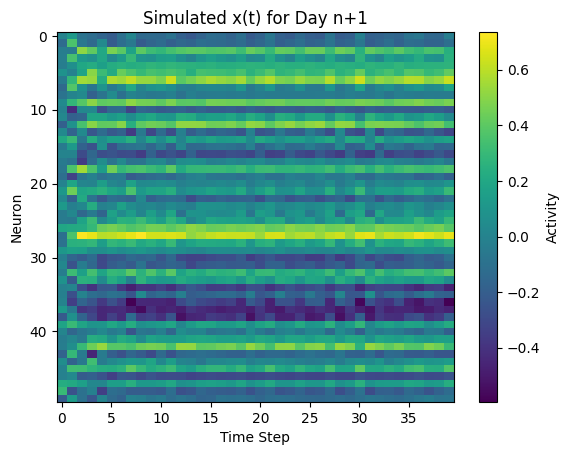

In [ ]:
# Symmetry-Constrained PINN-RNN for Structured Drift Recovery
# ===========================================================
# This notebook simulates representational drift across days and trains a physics-informed RNN
# to learn structured synaptic changes using a latent low-rank ODE.

# -----------------------
# Setup
# -----------------------
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchdiffeq import odeint
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy.linalg import subspace_angles

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -----------------------
# Generate Synthetic Data
# -----------------------
def generate_synthetic_dataset(T=10, S=5, K=40, N=50, r=3):
    W0 = 0.1 * torch.randn(N, N)
    U, _, Vt = torch.linalg.svd(W0)
    U = U[:, :r]
    V = Vt[:r, :].T

    B = 0.05 * torch.randn(N, 1)
    b = 0.1 * torch.randn(N)
    R = torch.randn(1, N) * 0.05

    t_vals = torch.linspace(0, 2 * np.pi, T)
    z = torch.stack([torch.sin(t_vals + np.pi * i / r) + 0.1 * t_vals for i in range(r)], dim=1)

    x_full = torch.zeros(T, S, K, N)
    v_full = torch.zeros(T, S, K)
    u_full = torch.zeros(T, S, K)

    for t in range(T):
        Wt = W0 + U @ torch.diag_embed(z[t].unsqueeze(0)).squeeze(0) @ V.T
        for s in range(S):
            v = torch.randn(K) * 0.5
            x = torch.zeros(K, N)
            x[0] = torch.randn(N) * 0.1
            for k in range(K - 1):
                x[k + 1] = torch.tanh(Wt @ x[k] + (B * v[k]).squeeze() + b)
            u_hat = (R @ x.T).squeeze()
            x_full[t, s] = x
            v_full[t, s] = v
            u_full[t, s] = u_hat + 0.05 * torch.randn(K)

    return x_full, v_full, u_full, W0, U, V, z, B, b, R

# Generate data
x, v, u, W0, U, V, z_true, B, b, R = generate_synthetic_dataset()
T, S, K, N = x.shape
rank = z_true.shape[1]

# -----------------------
# Dataset
# -----------------------
class SplitSessionDataset(Dataset):
    def __init__(self, x, v, u, train_days):
        self.x = x
        self.v = v
        self.u = u
        self.train_days = train_days
        self.S = x.shape[1]

    def __len__(self):
        return len(self.train_days) * self.S

    def __getitem__(self, idx):
        t_idx = self.train_days[idx // self.S]
        s = idx % self.S
        return self.x[t_idx, s], self.v[t_idx, s], self.u[t_idx, s], t_idx

# -----------------------
# Model
# -----------------------
class SlowODE(nn.Module):
    def __init__(self, r):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(r + 1, 64),
            nn.Tanh(),
            nn.Linear(64, r)
        )

    def forward(self, t, z):
        if isinstance(t, torch.Tensor):
            t = t.item()
        tvec = torch.full_like(z[:, :1], t)
        return self.net(torch.cat([z, tvec], dim=1))

class PINN_RNN(nn.Module):
    def __init__(self, N, r, U, V, W0, b_fixed):
        super().__init__()
        self.U = U.to(device)
        self.V = V.to(device)
        self.W0 = W0.to(device)
        self.z0 = nn.Parameter(torch.zeros(r))
        self.slow = SlowODE(r)
        self.B = nn.Parameter(torch.randn(N, 1) * 0.01)
        self.b_fixed = b_fixed.to(device)
        self.R = nn.Parameter(torch.randn(1, N) * 0.01)

    def rnn_cell(self, x, v, W):
        return torch.tanh((W @ x) + (self.B * v).squeeze() + self.b_fixed)

    def weights_over_time(self, T):
        times = torch.arange(T, dtype=torch.float32)
        z_traj = odeint(self.slow, self.z0.unsqueeze(0), times).squeeze(1)
        return self.W0 + self.U @ torch.diag_embed(z_traj) @ self.V.T

    def forward(self, x0, v, t, Ws):
        W = Ws[t]
        K, N = x0.shape
        x_list = [x0[0]]
        rec = dec = upd = 0
        for k in range(K - 1):
            up = self.rnn_cell(x_list[k], v[k], W)
            rec += (x_list[k] - x0[k]).pow(2).sum()
            dec += (self.R @ x_list[k] - v[k].unsqueeze(0)).pow(2).sum()
            upd += (up - self.rnn_cell(x_list[k], v[k], W)).pow(2).sum()
            x_list.append(up)
        return rec, dec, upd

# -----------------------
# Training
# -----------------------
train_days = list(range(T-1))
dataset = SplitSessionDataset(x, v, u, train_days)
loader = DataLoader(dataset, batch_size=4, shuffle=True)
b_fixed = x.mean(dim=(0,1,2)).to(device)
model = PINN_RNN(N, rank, U, V, W0, b_fixed=b_fixed).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

loss_history = {"rec": [], "dec": [], "upd": []}
epochs = 20

for ep in range(epochs):
    total_loss = 0
    for x_batch, v_batch, u_batch, t_batch in loader:
        x_batch, v_batch, t_batch = x_batch.to(device), v_batch.to(device), t_batch.to(device)
        Ws = model.weights_over_time(T)  # keep graph

        loss = 0
        for i in range(x_batch.shape[0]):
            R, D, U = model(x_batch[i], v_batch[i], t_batch[i], Ws)
            loss += R + D + 0.01 * U
            loss_history["rec"].append(R.item())
            loss_history["dec"].append(D.item())
            loss_history["upd"].append(U.item())

        loss /= x_batch.shape[0]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {ep:2d}: Loss = {total_loss/len(loader):.4f}")

# -----------------------
# Evaluation: Drift Recovery
# -----------------------
z_learned = odeint(model.slow, model.z0.unsqueeze(0), torch.arange(T).float()).squeeze(1).detach()

plt.figure()
for i in range(rank):
    plt.plot(z_true[:, i], '--', label=f'z_true[{i}]')
    plt.plot(z_learned[:, i], label=f'z_learned[{i}]')
plt.legend()
plt.title("True vs Learned z(t)")
plt.show()

# Subspace similarity
# def subspace_similarity(W1, W2, k=5):
#     _, _, V1 = torch.linalg.svd(W1)
#     _, _, V2 = torch.linalg.svd(W2)
#     return np.mean(np.cos(subspace_angles(V1[:, :k].cpu().numpy(), V2[:, :k].cpu().numpy())))

# Ws_true = []
# for t in range(T):
#     z_diag = torch.diag_embed(z_true[t].unsqueeze(0)).squeeze(0)
#     Wt = W0 + U @ z_diag @ V.T  # ensure [N, r] @ [r, r] @ [r, N]
#     Ws_true.append(Wt)
# Ws_learned = model.weights_over_time(T).detach()

# similarities = [subspace_similarity(Ws_learned[t], Ws_true[t]) for t in range(T)]
# plt.plot(similarities)
# plt.title("Subspace Similarity of W(t)")
# plt.ylim(0, 1)
# plt.show()

# -----------------------
# Day n+1 Prediction + Plotting
# -----------------------
T_plus1 = T
z_pred_all = odeint(model.slow, model.z0.unsqueeze(0), torch.arange(T_plus1).float()).squeeze(1).detach()
z_last = z_pred_all[-1].unsqueeze(0)  # [1, r]
z_diag = torch.diag_embed(z_last)[0]  # [r, r]
W_next = model.W0 + model.U @ z_diag @ model.V.T

x0 = x[-1, 0]  # use session T-1, trial 0 as seed
v_future = torch.randn(K).to(device)
x_sim = [x0[0]]
for k in range(K - 1):
    x_sim.append(torch.tanh(W_next @ x_sim[-1] + (model.B * v_future[k]).squeeze() + model.b_fixed))
x_sim = torch.stack(x_sim)

plt.figure()
plt.imshow(x_sim.detach().cpu().numpy().T, aspect='auto', cmap='viridis')
plt.title("Simulated x(t) for Day n+1")
plt.xlabel("Time Step")
plt.ylabel("Neuron")
plt.colorbar(label="Activity")
plt.show()


Device: cpu
Epoch 0: loss 3.838
Epoch 5: loss 3.419
Epoch 10: loss 3.325


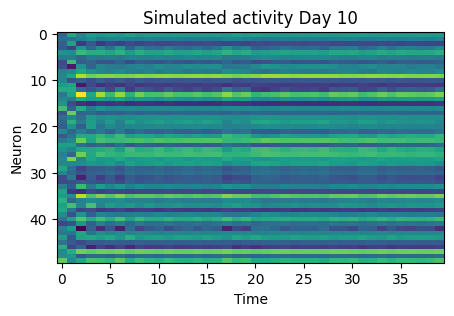

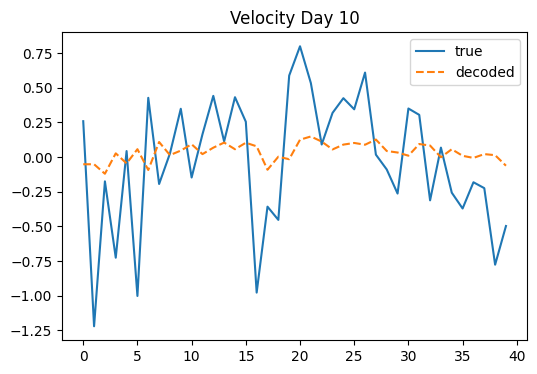

R² Day 10: 0.03953510997247034


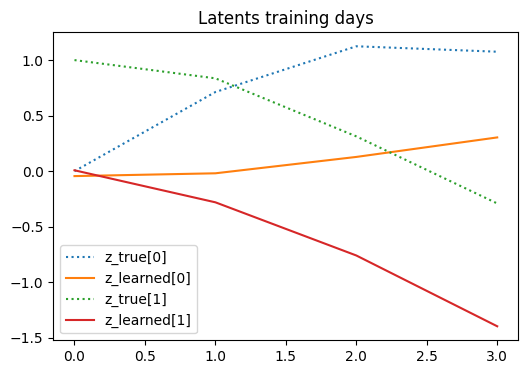

‖W10-W0‖_F: 7.208611488342285


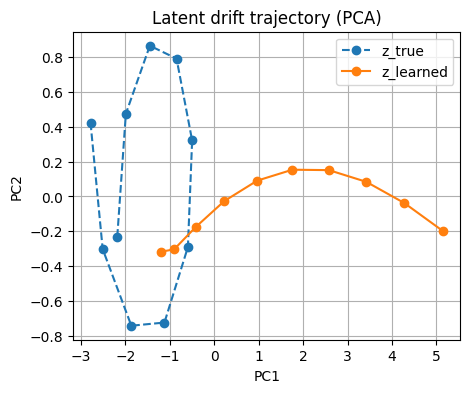

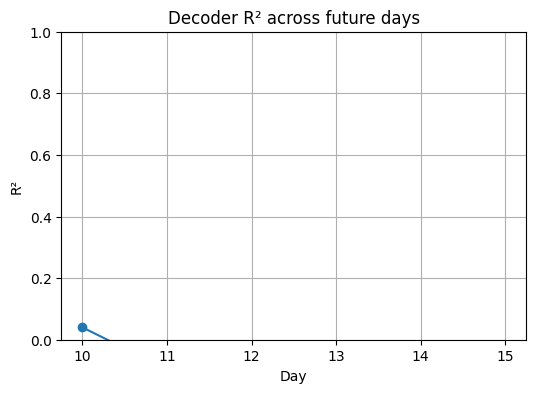

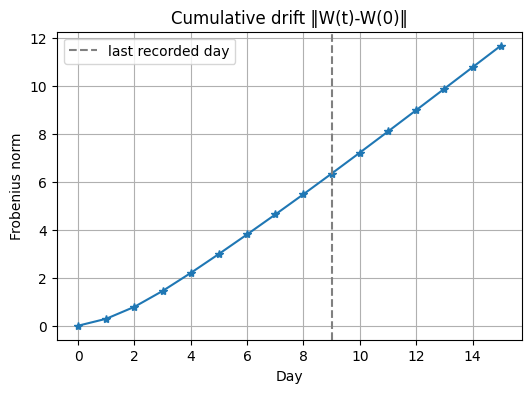

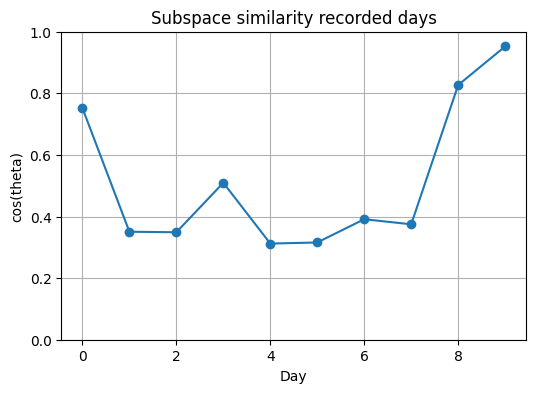

In [64]:
# Symmetry-Constrained PINN-RNN for Structured Drift Recovery
# ===========================================================
# This notebook trains on the FIRST 4 recorded days and then extrapolates to predict
# activity on Day 10 (a day never seen in data generation or training).
# It visualizes (i) latent drift, (ii) simulated activity for Day 10, and
# (iii) decoder accuracy on the extrapolated day.

# -----------------------
# Setup
# -----------------------
import torch, numpy as np, matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchdiffeq import odeint
from sklearn.metrics import r2_score
from scipy.linalg import subspace_angles

plt.rcParams['figure.figsize'] = (6,4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

# -----------------------
# Synthetic Data (10 recorded days)
# -----------------------
T_rec, S, K, N, rank = 10, 5, 40, 50, 2

W0 = 0.05*torch.randn(N,N)
U,_,Vt = torch.linalg.svd(W0)
U, V = U[:,:rank], Vt[:rank,:].T
B = 0.05*torch.randn(N,1);  b = 0.1*torch.randn(N);  R = 0.05*torch.randn(1,N)

t_vals = torch.linspace(0,2*np.pi,T_rec)
z_true = torch.stack([torch.sin(t_vals+np.pi*i/rank)+0.1*t_vals for i in range(rank)],1)

x = torch.zeros(T_rec,S,K,N); v = torch.zeros(T_rec,S,K)
for t in range(T_rec):
    Wt = W0 + U @ torch.diag_embed(z_true[t].unsqueeze(0))[0] @ V.T
    for s in range(S):
        v_ts = 0.5*torch.randn(K)
        x_ts = torch.zeros(K,N); x_ts[0] = 0.1*torch.randn(N)
        for k in range(K-1):
            x_ts[k+1] = torch.tanh(Wt@x_ts[k] + (B*v_ts[k]).squeeze() + b)
        v[t,s] = v_ts; x[t,s] = x_ts

a = x.mean((0,1,2))  # fixed bias/excitability

# -----------------------
# Dataset / Dataloader (train on first 4 days)
# -----------------------
class SplitDS(Dataset):
    def __init__(self,x,v,days): self.x,self.v,self.days,self.S=x,v,days,x.shape[1]
    def __len__(self): return len(self.days)*self.S
    def __getitem__(self,idx): t= self.days[idx//self.S]; s=idx%self.S; return self.x[t,s],self.v[t,s],t

train_days = list(range(4))
loader = DataLoader(SplitDS(x,v,train_days),batch_size=4,shuffle=True)

# -----------------------
# Model (slow‑ODE + fast RNN)
# -----------------------
class SlowODE(nn.Module):
    def __init__(self,r):
        super().__init__(); self.net=nn.Sequential(nn.Linear(r+1,64),nn.Tanh(),nn.Linear(64,r))
    def forward(self,t,z):
        t = t if isinstance(t,float) else t.item(); tvec=torch.full_like(z[:,:1],t)
        return self.net(torch.cat([z,tvec],1))

class PINN(nn.Module):
    def __init__(self):
        super().__init__(); self.U,self.V,self.W0 = U.to(device),V.to(device),W0.to(device)
        self.z0 = nn.Parameter(torch.zeros(rank)); self.slow = SlowODE(rank)
        self.B = nn.Parameter(B.clone()); self.R = nn.Parameter(R.clone()); self.b_fixed=a.to(device)
    def weights(self,T):
        times=torch.arange(T,dtype=torch.float32); z=odeint(self.slow,self.z0.unsqueeze(0),times).squeeze(1)
        return self.W0 + self.U @ torch.diag_embed(z) @ self.V.T
    def rnn_cell(self,xk,vk,W): return torch.tanh(W@xk + (self.B*vk).squeeze()+self.b_fixed)
    def forward(self,x0,v_seq,t_idx,Ws):
        W=Ws[t_idx]; rec=dec=0; x_prev=x0[0]
        for k in range(K-1):
            x_pred=self.rnn_cell(x_prev,v_seq[k],W)
            rec+= (x_pred - x0[k+1]).pow(2).sum(); dec+= (self.R@x_pred - v_seq[k]).pow(2)
            x_prev=x_pred
        return rec+0.1*dec

model=PINN().to(device); opt=torch.optim.Adam(model.parameters(),1e-3)

# -----------------------
# Training Loop
# -----------------------
for ep in range(15):
    L=0
    for xb,vb,tb in loader:
        xb,vb=xb.to(device),vb.to(device)
        Ws=model.weights(T_rec)
        loss=torch.stack([model(xb[i],vb[i],tb[i],Ws) for i in range(xb.size(0))]).mean()
        opt.zero_grad(); loss.backward(); opt.step(); L+=loss.item()
    if ep%5==0: print(f"Epoch {ep}: loss {L/len(loader):.3f}")

# -----------------------
# Extrapolate to Day 10
# -----------------------
T_future=1; T_pred=T_rec+T_future     # 11
z_pred=odeint(model.slow,model.z0.unsqueeze(0),torch.arange(T_pred).float()).squeeze(1).detach()
W10 = model.W0 + model.U @ torch.diag_embed(z_pred[10].unsqueeze(0))[0] @ model.V.T

# Simulate one trial on Day 10
v10 = 0.5*torch.randn(K).to(device); x10=[x[0,0,0].to(device)]
for k in range(K-1):
    x10.append(torch.tanh(W10@x10[-1] + (model.B*v10[k]).squeeze() + model.b_fixed))
x10=torch.stack(x10)

plt.figure(figsize=(5,3)); plt.imshow(x10.detach().cpu().T,aspect='auto',cmap='viridis')
plt.title('Simulated activity Day 10'); plt.xlabel('Time'); plt.ylabel('Neuron'); plt.show()

# Decoder performance Day 10
v_dec = (model.R@x10.T).squeeze().detach().cpu().numpy()
plt.figure(); plt.plot(v10.cpu(),label='true'); plt.plot(v_dec,'--',label='decoded'); plt.legend(); plt.title('Velocity Day 10'); plt.show()
print('R² Day 10:', r2_score(v10.cpu(),v_dec))

# Latent drift overlay (train days)
z_learn=odeint(model.slow,model.z0.unsqueeze(0),torch.arange(4).float()).squeeze(1).detach()
plt.figure();
for i in range(rank):
    plt.plot(z_true[:4,i],':',label=f'z_true[{i}]'); plt.plot(z_learn[:,i],label=f'z_learned[{i}]')
plt.title('Latents training days'); plt.legend(); plt.show()

# Drift magnitude W0→W10
W_pred=model.weights(T_pred).detach();
print('‖W10-W0‖_F:', torch.norm(W_pred[10]-W_pred[0]).item())

# =====================================================
# Extended evaluation: multi‑day extrapolation & metrics
# =====================================================
# We extrapolate an additional 6 unseen days (Days 10–15) and inspect
#    1) learned latent trajectory vs. ground‑truth (PCA overlay),
#    2) decoder accuracy (R²) across future days,
#    3) cumulative drift magnitude of weights,
#    4) subspace similarity between learned and ground‑truth W(t) for recorded days.

T_future_ext = 6
T_pred_ext   = T_rec + T_future_ext  # 16 total days (0–15)

# --- Latent trajectory prediction for all days (0–15) ---
z_pred_all = odeint(model.slow, model.z0.unsqueeze(0), torch.arange(T_pred_ext).float()).squeeze(1).detach()

# PCA overlay of true (days 0–9) vs. learned (0–15)
from sklearn.decomposition import PCA
all_z = torch.cat([z_true, z_pred_all[:T_rec]], dim=0).cpu().numpy()
labels = np.array(['true']*T_rec + ['learned']*T_rec)
Z_2d = PCA(n_components=2).fit_transform(all_z)
plt.figure(figsize=(5,4))
plt.plot(Z_2d[labels=='true',0], Z_2d[labels=='true',1], 'o--', label='z_true', color='C0')
plt.plot(Z_2d[labels=='learned',0], Z_2d[labels=='learned',1], 'o-',  label='z_learned', color='C1')
plt.title('Latent drift trajectory (PCA)')
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.legend(); plt.grid(True); plt.show()

# --- Decoder R² for days 10–15 ---
from sklearn.metrics import r2_score
r2_fut = []
for f in range(T_future_ext):
    t_future = T_rec + f
    z_diag = torch.diag_embed(z_pred_all[t_future].unsqueeze(0))[0]
    W_fut  = model.W0 + model.U @ z_diag @ model.V.T
    v_sim  = 0.5*torch.randn(K).to(device)
    x_sim  = [x[0,0,0].to(device)]
    for k in range(K-1):
        x_sim.append(torch.tanh(W_fut@x_sim[-1] + (model.B*v_sim[k]).squeeze() + model.b_fixed))
    x_sim  = torch.stack(x_sim)
    v_dec  = (model.R@x_sim.T).squeeze().detach().cpu().numpy()
    r2_fut.append(r2_score(v_sim.cpu().numpy(), v_dec))

plt.figure();
plt.plot(np.arange(T_rec, T_pred_ext), r2_fut, 'o-');
plt.title('Decoder R² across future days'); plt.xlabel('Day'); plt.ylabel('R²');
plt.ylim(0,1); plt.grid(True); plt.show()

# --- Weight drift magnitude relative to Day 0 ---
Ws_learn_ext = model.weights(T_pred_ext).detach()
mag = [torch.norm(Ws_learn_ext[t]-Ws_learn_ext[0]).item() for t in range(T_pred_ext)]
plt.figure(); plt.plot(mag,'-*');
plt.axvline(x=T_rec-1, color='grey', ls='--', label='last recorded day');
plt.title('Cumulative drift ‖W(t)-W(0)‖'); plt.xlabel('Day'); plt.ylabel('Frobenius norm'); plt.legend(); plt.grid(True); plt.show()

# --- Subspace similarity learned vs. ground‑truth for recorded days (0‑9) ---
from scipy.linalg import subspace_angles

def subspace_sim(W1,W2,k=5):
    _,_,V1 = torch.linalg.svd(W1); _,_,V2 = torch.linalg.svd(W2)
    return np.cos(subspace_angles(V1[:,:k].cpu(), V2[:,:k].cpu())).mean()

Ws_true = [W0 + U @ torch.diag_embed(z_true[t].unsqueeze(0))[0] @ V.T for t in range(T_rec)]
Ws_learn_train = Ws_learn_ext[:T_rec]
sims = [subspace_sim(Ws_learn_train[t], Ws_true[t]) for t in range(T_rec)]
plt.figure(); plt.plot(sims,'o-'); plt.title('Subspace similarity recorded days');
plt.xlabel('Day'); plt.ylabel('cos(theta)'); plt.ylim(0,1); plt.grid(True); plt.show()


Device: cpu
Epoch 0: loss 3.758
Epoch 5: loss 3.336
Epoch 10: loss 3.222
Epoch 15: loss 3.125
Epoch 20: loss 3.040
Epoch 25: loss 2.961


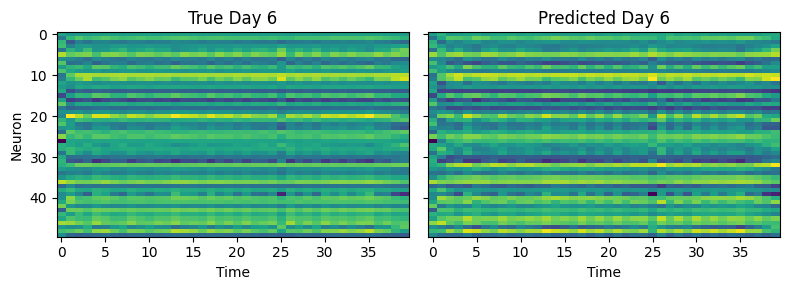

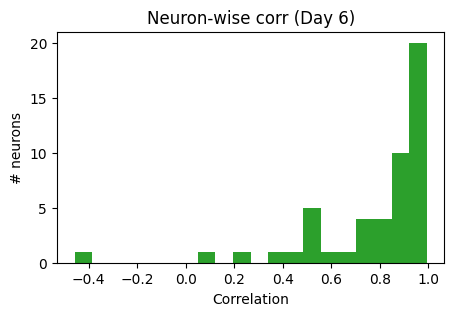

Mean corr Day 6: 0.774


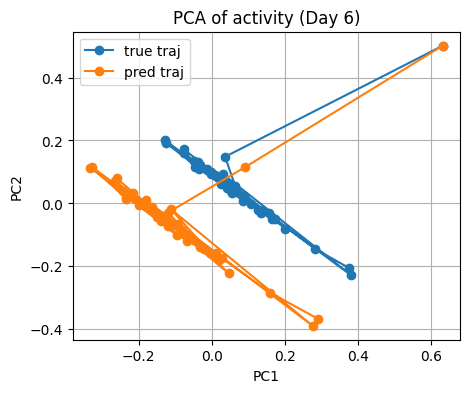

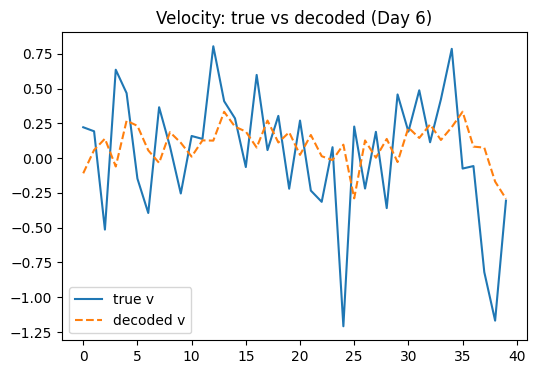

R² Day 6: -0.018088227940130652
‖W6 - W3‖_F: 1.6957989931106567


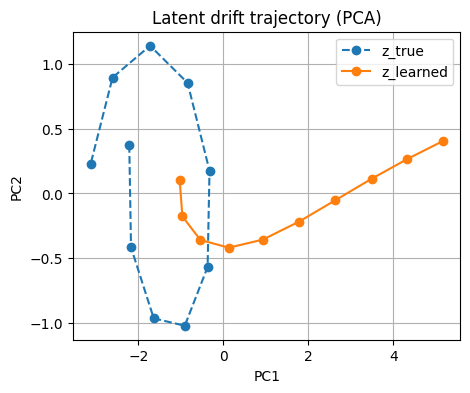

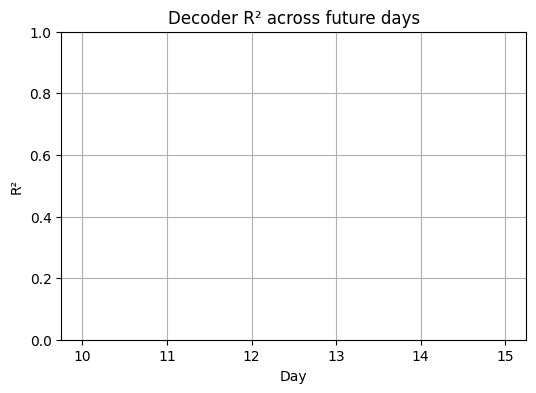

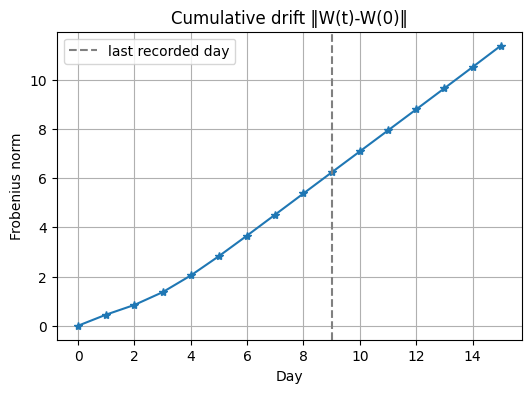

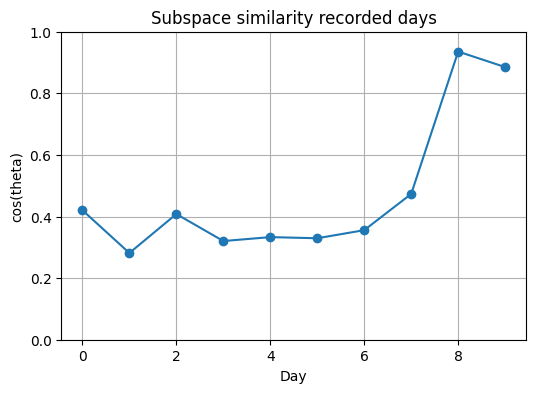

In [ ]:
# Symmetry-Constrained PINN-RNN for Structured Drift Recovery
# ===========================================================
# This notebook trains on the FIRST 4 recorded days and then extrapolates to predict
# activity on Day 10 (a day never seen in data generation or training).
# It visualizes (i) latent drift, (ii) simulated activity for Day 10, and
# (iii) decoder accuracy on the extrapolated day.

# -----------------------
# Setup
# -----------------------
import torch, numpy as np, matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchdiffeq import odeint
from sklearn.metrics import r2_score
from scipy.linalg import subspace_angles

plt.rcParams['figure.figsize'] = (6,4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

# -----------------------
# Synthetic Data (10 recorded days)
# -----------------------
T_rec, S, K, N, rank = 10, 5, 40, 50, 3

W0 = 0.05*torch.randn(N,N)
U,_,Vt = torch.linalg.svd(W0)
U, V = U[:,:rank], Vt[:rank,:].T
B = 0.05*torch.randn(N,1);  b = 0.1*torch.randn(N);  R = 0.05*torch.randn(1,N)

t_vals = torch.linspace(0,2*np.pi,T_rec)
z_true = torch.stack([torch.sin(t_vals+np.pi*i/rank)+0.1*t_vals for i in range(rank)],1)

x = torch.zeros(T_rec,S,K,N); v = torch.zeros(T_rec,S,K)
for t in range(T_rec):
    Wt = W0 + U @ torch.diag_embed(z_true[t].unsqueeze(0))[0] @ V.T
    for s in range(S):
        v_ts = 0.5*torch.randn(K)
        x_ts = torch.zeros(K,N); x_ts[0] = 0.1*torch.randn(N)
        for k in range(K-1):
            x_ts[k+1] = torch.tanh(Wt@x_ts[k] + (B*v_ts[k]).squeeze() + b)
        v[t,s] = v_ts; x[t,s] = x_ts

a = x.mean((0,1,2))  # fixed bias/excitability

# -----------------------
# Dataset / Dataloader (train on first 4 days)
# -----------------------
class SplitDS(Dataset):
    def __init__(self,x,v,days): self.x,self.v,self.days,self.S=x,v,days,x.shape[1]
    def __len__(self): return len(self.days)*self.S
    def __getitem__(self,idx): t= self.days[idx//self.S]; s=idx%self.S; return self.x[t,s],self.v[t,s],t

train_days = list(range(4))
loader = DataLoader(SplitDS(x,v,train_days),batch_size=4,shuffle=True)

# -----------------------
# Model (slow‑ODE + fast RNN)
# -----------------------
class SlowODE(nn.Module):
    def __init__(self,r):
        super().__init__(); self.net=nn.Sequential(nn.Linear(r+1,64),nn.Tanh(),nn.Linear(64,r))
    def forward(self,t,z):
        t = t if isinstance(t,float) else t.item(); tvec=torch.full_like(z[:,:1],t)
        return self.net(torch.cat([z,tvec],1))

class PINN(nn.Module):
    def __init__(self):
        super().__init__(); self.U,self.V,self.W0 = U.to(device),V.to(device),W0.to(device)
        self.z0 = nn.Parameter(torch.zeros(rank)); self.slow = SlowODE(rank)
        self.B = nn.Parameter(B.clone()); self.R = nn.Parameter(R.clone()); self.b_fixed=a.to(device)
    def weights(self,T):
        times=torch.arange(T,dtype=torch.float32); z=odeint(self.slow,self.z0.unsqueeze(0),times).squeeze(1)
        return self.W0 + self.U @ torch.diag_embed(z) @ self.V.T
    def rnn_cell(self,xk,vk,W): return torch.tanh(W@xk + (self.B*vk).squeeze()+self.b_fixed)
    def forward(self,x0,v_seq,t_idx,Ws):
        W=Ws[t_idx]; rec=dec=0; x_prev=x0[0]
        for k in range(K-1):
            x_pred=self.rnn_cell(x_prev,v_seq[k],W)
            rec+= (x_pred - x0[k+1]).pow(2).sum(); dec+= (self.R@x_pred - v_seq[k]).pow(2)
            x_prev=x_pred
        return rec+0.1*dec

model=PINN().to(device); opt=torch.optim.Adam(model.parameters(),1e-3)

# -----------------------
# Training Loop
# -----------------------
for ep in range(30):
    L=0
    for xb,vb,tb in loader:
        xb,vb=xb.to(device),vb.to(device)
        Ws=model.weights(T_rec)
        loss=torch.stack([model(xb[i],vb[i],tb[i],Ws) for i in range(xb.size(0))]).mean()
        opt.zero_grad(); loss.backward(); opt.step(); L+=loss.item()
    if ep%5==0: print(f"Epoch {ep}: loss {L/len(loader):.3f}")

# -----------------------
# Extrapolate to **Day 6** (unseen in training)
# -----------------------

test_day = 5  # index 6  (7th recorded session)
T_pred = test_day + 1          # we need weights up to and including day 6
z_pred = odeint(model.slow, model.z0.unsqueeze(0), torch.arange(T_pred).float()).squeeze(1).detach()
W6_pred = model.W0 + model.U @ torch.diag_embed(z_pred[test_day].unsqueeze(0))[0] @ model.V.T

# --- ground‑truth W6 from synthetic generator ---
W6_true = W0 + U @ torch.diag_embed(z_true[test_day].unsqueeze(0))[0] @ V.T

# === Simulate 1 trial on Day 6 using *true velocity* ===
vel6 = v[test_day,0].to(device)          # use velocity from session 6, trial 0
x_seed = x[test_day,0,0].to(device)      # start state same as ground truth

# Ground truth trajectory already stored in x[test_day,0]
true_traj = x[test_day,0].to(device)

# Predicted trajectory using learned W6_pred
pred_traj = [x_seed]
for k in range(K-1):
    pred_traj.append(torch.tanh(W6_pred @ pred_traj[-1] + (model.B*vel6[k]).squeeze() + model.b_fixed))
pred_traj = torch.stack(pred_traj)

# --- Plot heat‑maps side‑by‑side ---
fig,axs = plt.subplots(1,2,figsize=(8,3),sharey=True)
axs[0].imshow(true_traj.detach().cpu().T,aspect='auto',cmap='viridis'); axs[0].set_title('True Day 6')
axs[1].imshow(pred_traj.detach().cpu().T,aspect='auto',cmap='viridis'); axs[1].set_title('Predicted Day 6')
for ax in axs: ax.set_xlabel('Time'); axs[0].set_ylabel('Neuron')
plt.tight_layout(); plt.show()

# --- Neuron‑wise Pearson correlation ---
true_np = true_traj.detach().cpu().numpy(); pred_np = pred_traj.detach().cpu().numpy()
cc = [np.corrcoef(true_np[:,n], pred_np[:,n])[0,1] for n in range(N)]
plt.figure(figsize=(5,3)); plt.hist(cc,bins=20,color='C2'); plt.title('Neuron‑wise corr (Day 6)');
plt.xlabel('Correlation'); plt.ylabel('# neurons'); plt.show();
print('Mean corr Day 6:', np.nanmean(cc).round(3))

# --- PCA state‑space comparison (Day 6) ---
from sklearn.decomposition import PCA
comb = np.vstack([true_np, pred_np])            # shape [2K, N]
proj = PCA(n_components=2).fit_transform(comb)   # 2D embedding
true_proj = proj[:K]; pred_proj = proj[K:]
plt.figure(figsize=(5,4))
plt.plot(true_proj[:,0], true_proj[:,1],'o-',label='true traj')
plt.plot(pred_proj[:,0], pred_proj[:,1],'o-',label='pred traj')
plt.title('PCA of activity (Day 6)'); plt.xlabel('PC1'); plt.ylabel('PC2'); plt.legend(); plt.grid(True); plt.show()

# --- Decoder performance Day 6 ---
vel_dec = (model.R @ pred_traj.T).squeeze().detach().cpu().numpy()
plt.figure(); plt.plot(vel6.cpu(),label='true v'); plt.plot(vel_dec,'--',label='decoded v');
plt.title('Velocity: true vs decoded (Day 6)'); plt.legend(); plt.show();
print('R² Day 6:', r2_score(vel6.cpu(), vel_dec))

# Drift magnitude W3 → W6
Ws_pred_all = model.weights(test_day+1).detach();
print('‖W6 - W3‖_F:', torch.norm(Ws_pred_all[test_day]-Ws_pred_all[3]).item())

# =====================================================
# Extended evaluation: multi‑day extrapolation & metrics
# =====================================================
# We extrapolate an additional 6 unseen days (Days 10–15) and inspect
#    1) learned latent trajectory vs. ground‑truth (PCA overlay),
#    2) decoder accuracy (R²) across future days,
#    3) cumulative drift magnitude of weights,
#    4) subspace similarity between learned and ground‑truth W(t) for recorded days.

T_future_ext = 6
T_pred_ext   = T_rec + T_future_ext  # 16 total days (0–15)

# --- Latent trajectory prediction for all days (0–15) ---
z_pred_all = odeint(model.slow, model.z0.unsqueeze(0), torch.arange(T_pred_ext).float()).squeeze(1).detach()

# PCA overlay of true (days 0–9) vs. learned (0–15)
from sklearn.decomposition import PCA
all_z = torch.cat([z_true, z_pred_all[:T_rec]], dim=0).cpu().numpy()
labels = np.array(['true']*T_rec + ['learned']*T_rec)
Z_2d = PCA(n_components=2).fit_transform(all_z)
plt.figure(figsize=(5,4))
plt.plot(Z_2d[labels=='true',0], Z_2d[labels=='true',1], 'o--', label='z_true', color='C0')
plt.plot(Z_2d[labels=='learned',0], Z_2d[labels=='learned',1], 'o-',  label='z_learned', color='C1')
plt.title('Latent drift trajectory (PCA)')
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.legend(); plt.grid(True); plt.show()

# --- Decoder R² for days 10–15 ---
from sklearn.metrics import r2_score
r2_fut = []
for f in range(T_future_ext):
    t_future = T_rec + f
    z_diag = torch.diag_embed(z_pred_all[t_future].unsqueeze(0))[0]
    W_fut  = model.W0 + model.U @ z_diag @ model.V.T
    v_sim  = 0.5*torch.randn(K).to(device)
    x_sim  = [x[0,0,0].to(device)]
    for k in range(K-1):
        x_sim.append(torch.tanh(W_fut@x_sim[-1] + (model.B*v_sim[k]).squeeze() + model.b_fixed))
    x_sim  = torch.stack(x_sim)
    v_dec  = (model.R@x_sim.T).squeeze().detach().cpu().numpy()
    r2_fut.append(r2_score(v_sim.cpu().numpy(), v_dec))

plt.figure();
plt.plot(np.arange(T_rec, T_pred_ext), r2_fut, 'o-');
plt.title('Decoder R² across future days'); plt.xlabel('Day'); plt.ylabel('R²');
plt.ylim(0,1); plt.grid(True); plt.show()

# --- Weight drift magnitude relative to Day 0 ---
Ws_learn_ext = model.weights(T_pred_ext).detach()
mag = [torch.norm(Ws_learn_ext[t]-Ws_learn_ext[0]).item() for t in range(T_pred_ext)]
plt.figure(); plt.plot(mag,'-*');
plt.axvline(x=T_rec-1, color='grey', ls='--', label='last recorded day');
plt.title('Cumulative drift ‖W(t)-W(0)‖'); plt.xlabel('Day'); plt.ylabel('Frobenius norm'); plt.legend(); plt.grid(True); plt.show()

# --- Subspace similarity learned vs. ground‑truth for recorded days (0‑9) ---
from scipy.linalg import subspace_angles

def subspace_sim(W1,W2,k=5):
    _,_,V1 = torch.linalg.svd(W1); _,_,V2 = torch.linalg.svd(W2)
    return np.cos(subspace_angles(V1[:,:k].cpu(), V2[:,:k].cpu())).mean()

Ws_true = [W0 + U @ torch.diag_embed(z_true[t].unsqueeze(0))[0] @ V.T for t in range(T_rec)]
Ws_learn_train = Ws_learn_ext[:T_rec]
sims = [subspace_sim(Ws_learn_train[t], Ws_true[t]) for t in range(T_rec)]
plt.figure(); plt.plot(sims,'o-'); plt.title('Subspace similarity recorded days');
plt.xlabel('Day'); plt.ylabel('cos(theta)'); plt.ylim(0,1); plt.grid(True); plt.show()


Device: cpu
Epoch 0: loss 4.653
Epoch 5: loss 3.618
Epoch 10: loss 3.437
Epoch 15: loss 3.330
Epoch 20: loss 3.235
Epoch 25: loss 3.150
Epoch 30: loss 3.073
Epoch 35: loss 3.002
Epoch 40: loss 2.938
Epoch 45: loss 2.879
Epoch 50: loss 2.826
Epoch 55: loss 2.778
Epoch 60: loss 2.734
Epoch 65: loss 2.694
Epoch 70: loss 2.659
Epoch 75: loss 2.625
Epoch 80: loss 2.594
Epoch 85: loss 2.568
Epoch 90: loss 2.543
Epoch 95: loss 2.521


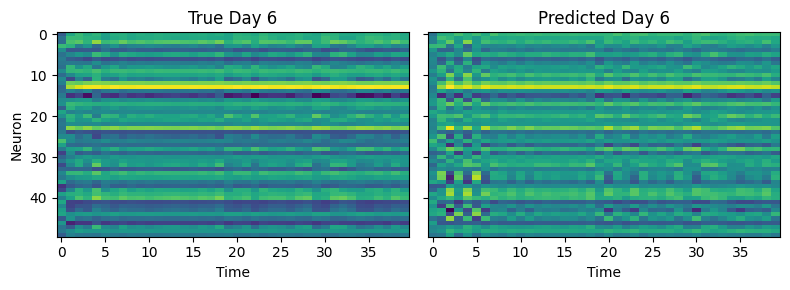

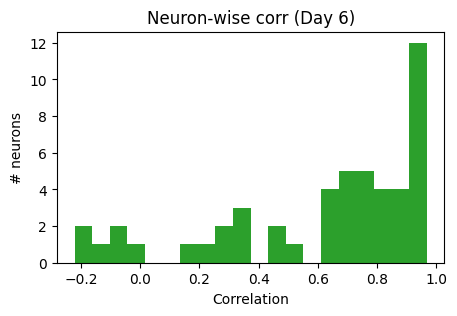

Mean corr Day 6: 0.61


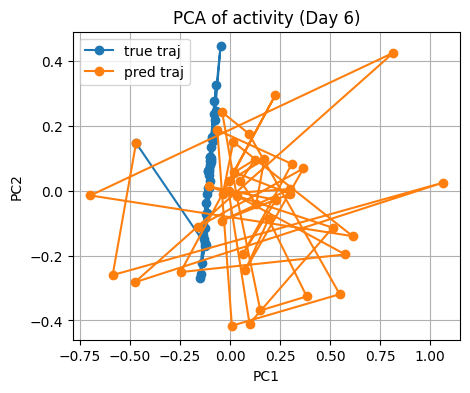

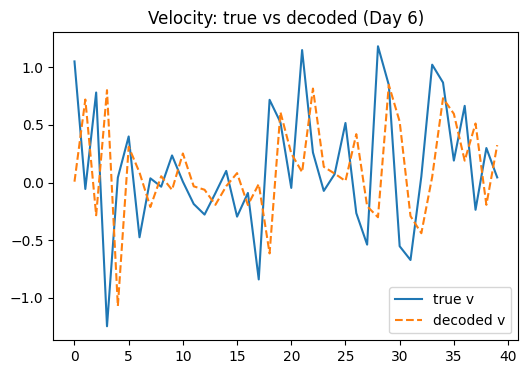

R² Day 6: -0.6437655827196702
‖W6 - W3‖_F: 4.0791335105896


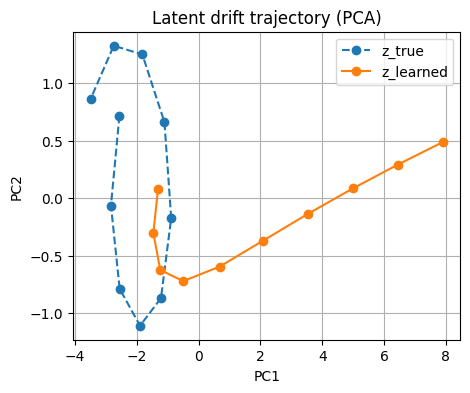

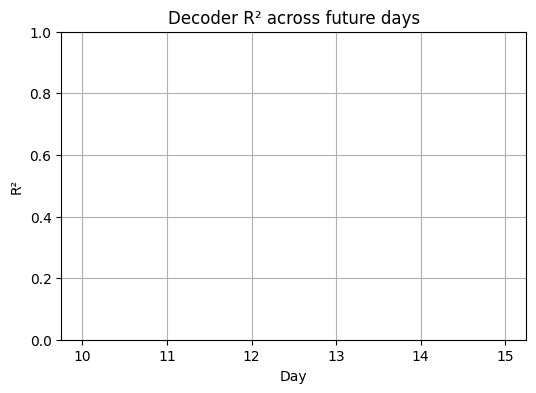

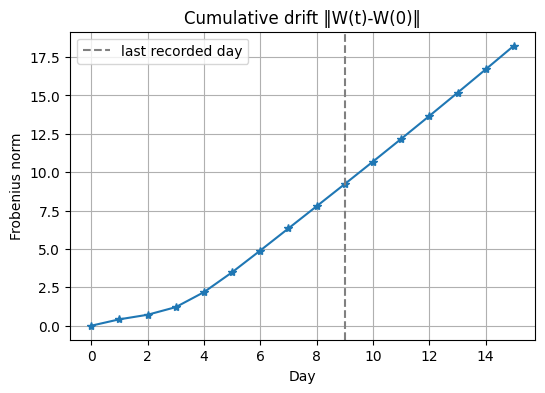

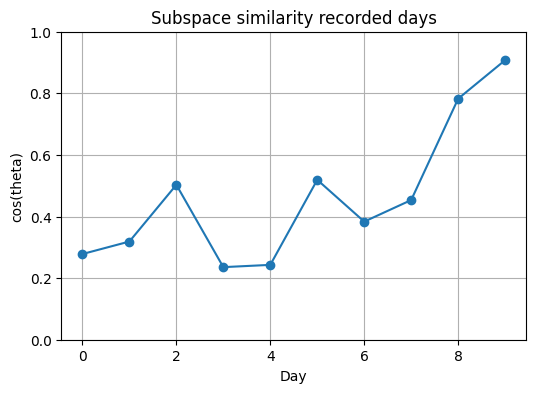

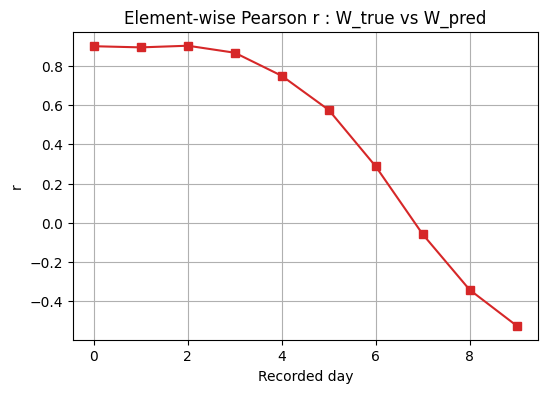

In [79]:
# Symmetry-Constrained PINN-RNN for Structured Drift Recovery
# ===========================================================
# This notebook trains on the FIRST 4 recorded days and then extrapolates to predict
# activity on Day 10 (a day never seen in data generation or training).
# It visualizes (i) latent drift, (ii) simulated activity for Day 10, and
# (iii) decoder accuracy on the extrapolated day.

# -----------------------
# Setup
# -----------------------
import torch, numpy as np, matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchdiffeq import odeint
from sklearn.metrics import r2_score
from scipy.linalg import subspace_angles

plt.rcParams['figure.figsize'] = (6,4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

# -----------------------
# Synthetic Data (10 recorded days)
# -----------------------
T_rec, S, K, N, rank = 10, 5, 40, 50, 3

W0 = 0.05*torch.randn(N,N)
U,_,Vt = torch.linalg.svd(W0)
U, V = U[:,:rank], Vt[:rank,:].T
B = 0.05*torch.randn(N,1);  b = 0.1*torch.randn(N);  R = 0.05*torch.randn(1,N)

t_vals = torch.linspace(0,2*np.pi,T_rec)
z_true = torch.stack([torch.sin(t_vals+np.pi*i/rank)+0.1*t_vals for i in range(rank)],1)

x = torch.zeros(T_rec,S,K,N); v = torch.zeros(T_rec,S,K)
for t in range(T_rec):
    Wt = W0 + U @ torch.diag_embed(z_true[t].unsqueeze(0))[0] @ V.T
    for s in range(S):
        v_ts = 0.5*torch.randn(K)
        x_ts = torch.zeros(K,N); x_ts[0] = 0.1*torch.randn(N)
        for k in range(K-1):
            x_ts[k+1] = torch.tanh(Wt@x_ts[k] + (B*v_ts[k]).squeeze() + b)
        v[t,s] = v_ts; x[t,s] = x_ts

a = x.mean((0,1,2))  # fixed bias/excitability

# -----------------------
# Dataset / Dataloader (train on first 4 days)
# -----------------------
class SplitDS(Dataset):
    def __init__(self,x,v,days): self.x,self.v,self.days,self.S=x,v,days,x.shape[1]
    def __len__(self): return len(self.days)*self.S
    def __getitem__(self,idx): t= self.days[idx//self.S]; s=idx%self.S; return self.x[t,s],self.v[t,s],t

train_days = list(range(4))
loader = DataLoader(SplitDS(x,v,train_days),batch_size=4,shuffle=True)

# -----------------------
# Model (slow‑ODE + fast RNN)
# -----------------------
class SlowODE(nn.Module):
    def __init__(self,r):
        super().__init__(); self.net=nn.Sequential(nn.Linear(r+1,64),nn.Tanh(),nn.Linear(64,r))
    def forward(self,t,z):
        t = t if isinstance(t,float) else t.item(); tvec=torch.full_like(z[:,:1],t)
        return self.net(torch.cat([z,tvec],1))

class PINN(nn.Module):
    def __init__(self):
        super().__init__(); self.U,self.V,self.W0 = U.to(device),V.to(device),W0.to(device)
        self.z0 = nn.Parameter(torch.zeros(rank)); self.slow = SlowODE(rank)
        self.B = nn.Parameter(B.clone()); self.R = nn.Parameter(R.clone()); self.b_fixed=a.to(device)
    def weights(self,T):
        times=torch.arange(T,dtype=torch.float32); z=odeint(self.slow,self.z0.unsqueeze(0),times).squeeze(1)
        return self.W0 + self.U @ torch.diag_embed(z) @ self.V.T
    def rnn_cell(self,xk,vk,W): return torch.tanh(W@xk + (self.B*vk).squeeze()+self.b_fixed)
    def forward(self,x0,v_seq,t_idx,Ws):
        W=Ws[t_idx]; rec=dec=0; x_prev=x0[0]
        for k in range(K-1):
            x_pred=self.rnn_cell(x_prev,v_seq[k],W)
            rec+= (x_pred - x0[k+1]).pow(2).sum(); dec+= (self.R@x_pred - v_seq[k]).pow(2)
            x_prev=x_pred
        return rec+0.1*dec

model=PINN().to(device); opt=torch.optim.Adam(model.parameters(),1e-3)

# -----------------------
# Training Loop
# -----------------------
for ep in range(100):
    L=0
    for xb,vb,tb in loader:
        xb,vb=xb.to(device),vb.to(device)
        Ws=model.weights(T_rec)
        loss=torch.stack([model(xb[i],vb[i],tb[i],Ws) for i in range(xb.size(0))]).mean()
        opt.zero_grad(); loss.backward(); opt.step(); L+=loss.item()
    if ep%5==0: print(f"Epoch {ep}: loss {L/len(loader):.3f}")

# -----------------------
# Extrapolate to **Day 6** (unseen in training)
# -----------------------

test_day = 6  # index 6  (7th recorded session)
T_pred = test_day + 1          # we need weights up to and including day 6
z_pred = odeint(model.slow, model.z0.unsqueeze(0), torch.arange(T_pred).float()).squeeze(1).detach()
W6_pred = model.W0 + model.U @ torch.diag_embed(z_pred[test_day].unsqueeze(0))[0] @ model.V.T

# --- ground‑truth W6 from synthetic generator ---
W6_true = W0 + U @ torch.diag_embed(z_true[test_day].unsqueeze(0))[0] @ V.T

# === Simulate 1 trial on Day 6 using *true velocity* ===
vel6 = v[test_day,0].to(device)          # use velocity from session 6, trial 0
x_seed = x[test_day,0,0].to(device)      # start state same as ground truth

# Ground truth trajectory already stored in x[test_day,0]
true_traj = x[test_day,0].to(device)

# Predicted trajectory using learned W6_pred
pred_traj = [x_seed]
for k in range(K-1):
    pred_traj.append(torch.tanh(W6_pred @ pred_traj[-1] + (model.B*vel6[k]).squeeze() + model.b_fixed))
pred_traj = torch.stack(pred_traj)

# --- Plot heat‑maps side‑by‑side ---
fig,axs = plt.subplots(1,2,figsize=(8,3),sharey=True)
axs[0].imshow(true_traj.detach().cpu().T,aspect='auto',cmap='viridis'); axs[0].set_title('True Day 6')
axs[1].imshow(pred_traj.detach().cpu().T,aspect='auto',cmap='viridis'); axs[1].set_title('Predicted Day 6')
for ax in axs: ax.set_xlabel('Time'); axs[0].set_ylabel('Neuron')
plt.tight_layout(); plt.show()

# --- Neuron‑wise Pearson correlation ---
true_np = true_traj.detach().cpu().numpy(); pred_np = pred_traj.detach().cpu().numpy()
cc = [np.corrcoef(true_np[:,n], pred_np[:,n])[0,1] for n in range(N)]
plt.figure(figsize=(5,3)); plt.hist(cc,bins=20,color='C2'); plt.title('Neuron‑wise corr (Day 6)');
plt.xlabel('Correlation'); plt.ylabel('# neurons'); plt.show();
print('Mean corr Day 6:', np.nanmean(cc).round(3))

# --- PCA state‑space comparison (Day 6) ---
from sklearn.decomposition import PCA
comb = np.vstack([true_np, pred_np])            # shape [2K, N]
proj = PCA(n_components=2).fit_transform(comb)   # 2D embedding
true_proj = proj[:K]; pred_proj = proj[K:]
plt.figure(figsize=(5,4))
plt.plot(true_proj[:,0], true_proj[:,1],'o-',label='true traj')
plt.plot(pred_proj[:,0], pred_proj[:,1],'o-',label='pred traj')
plt.title('PCA of activity (Day 6)'); plt.xlabel('PC1'); plt.ylabel('PC2'); plt.legend(); plt.grid(True); plt.show()

# --- Decoder performance Day 6 ---
vel_dec = (model.R @ pred_traj.T).squeeze().detach().cpu().numpy()
plt.figure(); plt.plot(vel6.cpu(),label='true v'); plt.plot(vel_dec,'--',label='decoded v');
plt.title('Velocity: true vs decoded (Day 6)'); plt.legend(); plt.show();
print('R² Day 6:', r2_score(vel6.cpu(), vel_dec))

# Drift magnitude W3 → W6
Ws_pred_all = model.weights(test_day+1).detach();
print('‖W6 - W3‖_F:', torch.norm(Ws_pred_all[test_day]-Ws_pred_all[3]).item())

# =====================================================
# Extended evaluation: multi‑day extrapolation & metrics
# =====================================================
# We extrapolate an additional 6 unseen days (Days 10–15) and inspect
#    1) learned latent trajectory vs. ground‑truth (PCA overlay),
#    2) decoder accuracy (R²) across future days,
#    3) cumulative drift magnitude of weights,
#    4) subspace similarity between learned and ground‑truth W(t) for recorded days.

T_future_ext = 6
T_pred_ext   = T_rec + T_future_ext  # 16 total days (0–15)

# --- Latent trajectory prediction for all days (0–15) ---
z_pred_all = odeint(model.slow, model.z0.unsqueeze(0), torch.arange(T_pred_ext).float()).squeeze(1).detach()

# PCA overlay of true (days 0–9) vs. learned (0–15)
from sklearn.decomposition import PCA
all_z = torch.cat([z_true, z_pred_all[:T_rec]], dim=0).cpu().numpy()
labels = np.array(['true']*T_rec + ['learned']*T_rec)
Z_2d = PCA(n_components=2).fit_transform(all_z)
plt.figure(figsize=(5,4))
plt.plot(Z_2d[labels=='true',0], Z_2d[labels=='true',1], 'o--', label='z_true', color='C0')
plt.plot(Z_2d[labels=='learned',0], Z_2d[labels=='learned',1], 'o-',  label='z_learned', color='C1')
plt.title('Latent drift trajectory (PCA)')
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.legend(); plt.grid(True); plt.show()

# --- Decoder R² for days 10–15 ---
from sklearn.metrics import r2_score
r2_fut = []
for f in range(T_future_ext):
    t_future = T_rec + f
    z_diag = torch.diag_embed(z_pred_all[t_future].unsqueeze(0))[0]
    W_fut  = model.W0 + model.U @ z_diag @ model.V.T
    v_sim  = 0.5*torch.randn(K).to(device)
    x_sim  = [x[0,0,0].to(device)]
    for k in range(K-1):
        x_sim.append(torch.tanh(W_fut@x_sim[-1] + (model.B*v_sim[k]).squeeze() + model.b_fixed))
    x_sim  = torch.stack(x_sim)
    v_dec  = (model.R@x_sim.T).squeeze().detach().cpu().numpy()
    r2_fut.append(r2_score(v_sim.cpu().numpy(), v_dec))

plt.figure();
plt.plot(np.arange(T_rec, T_pred_ext), r2_fut, 'o-');
plt.title('Decoder R² across future days'); plt.xlabel('Day'); plt.ylabel('R²');
plt.ylim(0,1); plt.grid(True); plt.show()

# --- Weight drift magnitude relative to Day 0 ---
Ws_learn_ext = model.weights(T_pred_ext).detach()
mag = [torch.norm(Ws_learn_ext[t]-Ws_learn_ext[0]).item() for t in range(T_pred_ext)]
plt.figure(); plt.plot(mag,'-*');
plt.axvline(x=T_rec-1, color='grey', ls='--', label='last recorded day');
plt.title('Cumulative drift ‖W(t)-W(0)‖'); plt.xlabel('Day'); plt.ylabel('Frobenius norm'); plt.legend(); plt.grid(True); plt.show()

# --- Subspace similarity learned vs. ground‑truth for recorded days (0‑9) ---
from scipy.linalg import subspace_angles

def subspace_sim(W1,W2,k=5):
    _,_,V1 = torch.linalg.svd(W1); _,_,V2 = torch.linalg.svd(W2)
    return np.cos(subspace_angles(V1[:,:k].cpu(), V2[:,:k].cpu())).mean()

Ws_true = [W0 + U @ torch.diag_embed(z_true[t].unsqueeze(0))[0] @ V.T for t in range(T_rec)]
Ws_learn_train = Ws_learn_ext[:T_rec]
sims = [subspace_sim(Ws_learn_train[t], Ws_true[t]) for t in range(T_rec)]
plt.figure(); plt.plot(sims,'o-'); plt.title('Subspace similarity recorded days');
plt.xlabel('Day'); plt.ylabel('cos(theta)'); plt.ylim(0,1); plt.grid(True); plt.show()

# ----------------------------------------------------------------
# NEW: Weight‑matrix correlation (element‑wise) per recorded day
# ----------------------------------------------------------------
flat_corr = []
for t in range(T_rec):
    w_true_flat  = Ws_true[t ].flatten().cpu().numpy()
    w_pred_flat  = Ws_learn_train[t].flatten().cpu().numpy()
    flat_corr.append( np.corrcoef(w_true_flat, w_pred_flat)[0,1] )

plt.figure(); plt.plot(flat_corr,'s-',color='C3');
plt.title('Element‑wise Pearson r : W_true vs W_pred');
plt.xlabel('Recorded day'); plt.ylabel('r'); plt.grid(True); plt.show()
